# HRV-Stress_hrv

## make peak data data

In [1]:
import os
import os.path as osp
import pandas as pd
import numpy as np
import copy
from scipy import signal
from scipy.interpolate import Akima1DInterpolator
import pickle
import math

In [2]:
path_data = 'data/individual'
name_input_file = 'heartrate.csv' # public raw data of nback

In [3]:
subject_list = os.listdir(path_data)

In [4]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

### mode: detrending using interpolator

```python
moving_average_window = 330 # 330 ms
peak_distance = 350 # 350 ms
max_hrv_window = 30000
step_size = 10
detrending_interpolator = 'akima'
```

In [5]:
moving_average_window = 330 # 330 ms
peak_distance = 350 # 350 ms
max_hrv_window = 30000

# for detrending using interpolator
step_size = 10 # 10 ms
detrending_interpolator = 'akima'
shift = (moving_average_window//step_size)-1

# # for detrending without interpolator
# step_size = 1 # 1 ms
# detrending_interpolator = ''

In [6]:
print_subject_name = False

for subject_name in subject_list:
    if print_subject_name == True:
        print(subject_name)
    
    # read
    df = pd.read_csv(osp.join(path_data,subject_name,name_input_file))
    
    # check n-back first time_stamp and remove all before first - window_size - max_hrv_window
    df_nback = pd.read_csv(osp.join(path_data,subject_name,'nback.csv'))
    start_time = df_nback['time_stamp'].iloc[0] - moving_average_window - max_hrv_window
    end_time = df_nback['time_stamp'].iloc[-1]
    
    for idx, val in enumerate(df['time_stamp']):
        if val >= start_time:
            break
    if idx > 0:
        idx -= 1
    df.drop(df.index[0:idx], inplace = True)
    
    for idx, val in enumerate(df['time_stamp'][::-1]):
        if val <= end_time:
            break
    if idx > 0:
        idx -= 1
    df.drop(df.index[-idx::], inplace = True)
    
    df.reset_index(inplace=True,drop=True)

    if detrending_interpolator == 'akima':
        # detrending using interpolator (make data evenly spaced)
        # smoothing using akima, with step_size correction
        start_time = df['time_stamp'].iloc[0]
        start_time = (math.ceil(start_time/step_size))*step_size
        end_time = df['time_stamp'].iloc[-1]
        end_time = (math.floor(end_time/step_size))*step_size

        time_stamp_smooth = np.linspace(start_time, end_time, num=(end_time-start_time)//step_size+1, endpoint=True)

        red_interpolator = Akima1DInterpolator(df['time_stamp'].to_numpy(), df['red'].to_numpy())
        red = red_interpolator(time_stamp_smooth)

        # rolling moving average
        red_average = moving_average(red, n=moving_average_window//step_size)
        red_detrend = red[shift::] - red_average
        time_stamp_shift = time_stamp_smooth[shift::]

    else:
        # detrending without interpolator (without making time_stamp evenly spaced)
        # time window based interpolator
        start_time = df['time_stamp'].iloc[0]
        start_time = start_time + moving_average_window

        for idx, val in df['time_stamp'].iteritems():
            if val >= start_time:
                break
        if idx > 0:
            idx -= 1

        red = df['red'].to_numpy()
        time_stamp = df['time_stamp'].to_numpy()
        red_shift = df['red'][idx:].to_numpy()
        time_stamp_shift = df['time_stamp'][idx:].to_numpy()
        red_moving_average = np.array([np.mean(red[(time_stamp > t-moving_average_window) * (time_stamp <= t)]) for t in time_stamp_shift])
        red_detrend = red_shift - red_moving_average

    # save detrended signal
    with open(osp.join(path_data,subject_name,'red_detrend_and_time_stamp_shift.pickle'), 'wb') as handle:
        pickle.dump([red_detrend,time_stamp_shift], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
delete_pickled_file_after_read = True

for subject_name in subject_list:
    path_detrend = osp.join(path_data,subject_name,'red_detrend_and_time_stamp_shift.pickle') 
    if os.path.exists(path_detrend):
        with open(path_detrend, 'rb') as handle:
            red_detrend, time_stamp_shift = pickle.load(handle)

        # delete pickled
        if delete_pickled_file_after_read == True:
            os.remove(path_detrend)
    
    # smoothing using akima (mostly for unevenly spaced data)
    if detrending_interpolator == 'akima':
        start_time = time_stamp_shift[0]
        end_time = time_stamp_shift[-1]
        time_stamp_smooth = np.linspace(start_time, end_time, num=int(end_time-start_time)//step_size, endpoint=True)
        red_interpolator = Akima1DInterpolator(time_stamp_shift, red_detrend)
        red_smooth = red_interpolator(time_stamp_smooth)
    else:
        time_stamp_smooth = time_stamp_shift
        red_smooth = red_detrend
    
    # peak finder
    peaks, _ = signal.find_peaks(red_smooth, distance=peak_distance//step_size)

    # time_stamp of peak
    df_time_stamp_peak = pd.DataFrame({'time_stamp':time_stamp_smooth[peaks]})
    
    # save
    df_time_stamp_peak.to_csv(osp.join(path_data,subject_name,'peaks.csv'), index=False)

## Peaks Visualization

In [8]:
# # edit to plot other than the last subject
# import matplotlib.pyplot as plt
# plt.plot(red_smooth)
# print(peaks)

# HRV-Stress_n-back-test

## read csv

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
path_data = 'data/individual'

In [11]:
subject_list = os.listdir(path_data)

In [12]:
def get_mrr(rr):
    '''rr: distance between peaks in ms'''
    return np.mean(rr)
def get_mhr(rr):
    return np.mean(60000/rr)
def get_sdrr(rr, mrr):
    num = np.sum([np.math.pow(x,2) for x in rr-mrr])
    return np.sqrt(num/(np.size(rr)-1))
def get_sdhr(rr, mhr):
    num = np.sum([np.math.pow(x,2) for x in (60000/rr)-mhr])
    return np.sqrt(num/(np.size(rr)-1))
def get_cvrr(sdrr, mrr):
    return sdrr*100/mrr
def get_rmssd(rr):
    num = np.sum([np.math.pow(x,2) for x in np.diff(rr)])
    return np.sqrt(num/(np.size(rr)-1))
def get_prr20(rr):
    arr = np.abs(np.diff(rr))
    count = 0
    for arr_i in arr:
        if arr_i > 20:
            count += 1 
    return count*100 / (np.size(rr)-1)
def get_prr50(rr):
    arr = np.abs(np.diff(rr))
    count = 0
    for arr_i in arr:
        if arr_i > 50:
            count += 1 
    return count*100 / (np.size(rr)-1)

### mode: minmax, include outlier, no penalty 

```python
hrv_windows = [30000]
```

In [13]:
scaler = MinMaxScaler()
hrv_windows = [30000]

for subject_name in subject_list:
    # read nback
    df = pd.read_csv(osp.join(path_data,subject_name,'nback.csv'))
    nback_original_columns = df.columns
    
    # read peaks
    peaks = pd.read_csv(osp.join(path_data,subject_name,'peaks.csv')).to_numpy()
    
    for hrv_window in hrv_windows:
        mrr = []; mhr = []; sdrr = []; sdhr = []; cvrr = []; rmssd = []; prr20 = []; prr50 = [];
        for time_stamp in df['time_stamp']:
            peaks_slice = peaks[(peaks > time_stamp - hrv_window) * (peaks <= time_stamp)]
            rr = np.diff(peaks_slice.flatten())
            mrr.append(get_mrr(rr))
            mhr.append(get_mhr(rr))
            sdrr.append(get_sdrr(rr, mrr[-1]))
            sdhr.append(get_sdhr(rr, mhr[-1]))
            cvrr.append(get_cvrr(sdrr[-1], mrr[-1]))
            rmssd.append(get_rmssd(rr))
            prr20.append(get_prr20(rr))
            prr50.append(get_prr50(rr))
        df['mrr_'+str(hrv_window)[:2]+'s'] = mrr
        df['mhr_'+str(hrv_window)[:2]+'s'] = mhr
        df['sdrr_'+str(hrv_window)[:2]+'s'] = sdrr
        df['sdhr_'+str(hrv_window)[:2]+'s'] = sdhr
        df['cvrr_'+str(hrv_window)[:2]+'s'] = cvrr
        df['rmsd_'+str(hrv_window)[:2]+'s'] = rmssd
        df['prr20_'+str(hrv_window)[:2]+'s'] = prr20
        df['prr50_'+str(hrv_window)[:2]+'s'] = prr50
    
    # reaction_time
    reaction_time = [0]
    idx = 1
    while True:
        try:
            reaction_time.append(df['time_stamp'][idx]-df['time_stamp'][idx-1])
            idx += 1
        except:
            break
    df['reaction_time'] = reaction_time
        
    # drop initial nback (value == 0)
    df.drop(df[df['value'] == 0].index, inplace = True)
    df.reset_index(inplace=True,drop=True)

    # save
    df.to_csv(osp.join(path_data,subject_name,'reaction_time_raw.csv'), index=False)
    
#     # penalty
#     col_names = ['reaction_time']
#     for penalty in np.arange(1.1,2.1,0.1):
#         col_name = 'reaction_time_penalized_'+str(penalty)[0:3]
#         col_names.append(col_name)
#         df[col_name] = df['reaction_time']
#         df.loc[df[df['value']==-1].index,col_name] = df['reaction_time'][df[df['value']==-1].index] * penalty
    
#     # remove reaction_time outlier 
#     lb = df['reaction_time'].quantile(.05)
#     ub = df['reaction_time'].quantile(.95)

#     inliers =df['reaction_time'].between(lb, ub)
#     index_to_drop = df[~inliers].index
#     df_inliers = df.drop(index_to_drop, inplace=False) # copy to make inliers only df and original
#     df_inliers.reset_index(inplace=True,drop=True)
    
#     # true only and penalized
#     df_inliers_true = df_inliers.drop(df_inliers[df_inliers['value'] == -1].index, inplace = False)
#     df_inliers_true.drop(columns=col_names[1:],inplace=True)
#     df_inliers_true.reset_index(inplace=True,drop=True)
    
#     df_inliers_penalized = df_inliers

#     df_true = df.drop(df[df['value'] == -1].index, inplace = False)
#     df_true.drop(columns=col_names[1:],inplace=True)
#     df_true.reset_index(inplace=True,drop=True)
    
    df_penalized = df

#     # save
#     df_inliers_true.to_csv(osp.join(path_data,subject_name,'reaction_time_true_inliers.csv'), index=False)
#     df_inliers_penalized.to_csv(osp.join(path_data,subject_name,'reaction_time_penalized_inliers.csv'), index=False)
#     df_true.to_csv(osp.join(path_data,subject_name,'reaction_time_true.csv'), index=False)
#     df_penalized.to_csv(osp.join(path_data,subject_name,'reaction_time_penalized.csv'), index=False)
    
    # minmax scaler
#     for col_name in df_inliers_true.columns:
#         if col_name not in nback_original_columns:
#             df_inliers_true[col_name] = scaler.fit_transform(df_inliers_true[col_name].values.reshape(-1, 1))
#     for col_name in df_inliers_penalized.columns:
#         if col_name not in nback_original_columns:
#             df_inliers_penalized[col_name] = scaler.fit_transform(df_inliers_penalized[col_name].values.reshape(-1, 1))
#     for col_name in df_true.columns:
#         if col_name not in nback_original_columns:
#             df_true[col_name] = scaler.fit_transform(df_true[col_name].values.reshape(-1, 1))
    for col_name in df_penalized.columns:
            if col_name not in nback_original_columns:
                df_penalized[col_name] = scaler.fit_transform(df_penalized[col_name].values.reshape(-1, 1))


    # save
#     df_inliers_true.to_csv(osp.join(path_data,subject_name,'reaction_time_true_inliers_minmax.csv'), index=False)
#     df_inliers_penalized.to_csv(osp.join(path_data,subject_name,'reaction_time_penalized_inliers_minmax.csv'), index=False)
#     df_true.to_csv(osp.join(path_data,subject_name,'reaction_time_true_minmax.csv'), index=False)
    df_penalized.to_csv(osp.join(path_data,subject_name,'reaction_time_penalized_minmax.csv'), index=False)

In [14]:
df.head()

,time_stamp,value,flag,mrr_30s,mhr_30s,sdrr_30s,sdhr_30s,cvrr_30s,rmsd_30s,prr20_30s,prr50_30s,reaction_time
0,1572545903015,1,11,0.527371,0.497205,0.851002,0.879203,0.848181,0.807411,0.786148,0.900033,0.125558
1,1572545907711,1,11,0.585767,0.449776,0.859896,0.901443,0.831753,0.640768,0.663947,0.819021,0.614802
2,1572545908912,1,11,0.624368,0.415761,0.859781,0.898247,0.815819,0.623753,0.608302,0.786230,0.141929
3,1572545910146,-1,11,0.547166,0.499349,0.894803,0.954899,0.881081,0.621571,0.562673,0.731798,0.146394
4,1572545911609,1,11,0.551290,0.499279,0.902977,0.966768,0.886970,0.600297,0.572296,0.679500,0.177378


## Check NaN and Inf

In [15]:
for subject_name in subject_list:
    # read
    df = pd.read_csv(osp.join(path_data,subject_name,'reaction_time_raw.csv'))
    for col in df.columns:
        if df[col].isnull().values.any():
            print(subject_name, col)

In [16]:
for subject_name in subject_list:
    # read
    df = pd.read_csv(osp.join(path_data,subject_name,'reaction_time_raw.csv'))
    for col in df.columns:
        if not df.index[np.isinf(df[col])].empty:
            print(subject_name, col)

## Elbow Method (Using K-Means CLustering)

In [17]:
from sklearn.cluster import KMeans

In [18]:
from kneed import KneeLocator

def kneed_elbow(model, x, fit_num=1, cluster_nums=range(2,10)):
    distortions = []
    for cluster_num in cluster_nums:
        model.n_clusters=cluster_num
        inertia = 0
        for _ in range(fit_num):
            model.fit(x)
            inertia += model.inertia_
        distortions.append(inertia/fit_num)
    return KneeLocator(cluster_nums, distortions, S=1.0, curve="convex", direction="decreasing")

In [19]:
# elbow (based on true only, with outliers drop, and no penalty)
elbow_list = []
kneedle_list = []
for subject_name in subject_list:
    # read
    path_input_file = osp.join(path_data,subject_name,'reaction_time_penalized_minmax.csv')
    df = pd.read_csv(path_input_file)

    # Instantiate the clustering model and visualizer
    cluster = KMeans()
    kneedle = kneed_elbow(cluster, df['reaction_time'].values.reshape(-1, 1))
    elbow_list.append(kneedle.knee) 
    kneedle_list.append(kneedle)
elbow_num = sum(elbow_list)//len(elbow_list)

# # result
# elbow_num = 4
print(elbow_num)

4


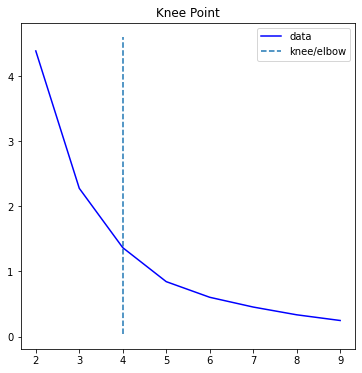

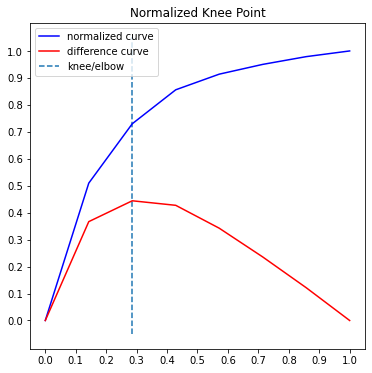

In [20]:
# sample plot
kneedle_list[0].plot_knee(); kneedle_list[0].plot_knee_normalized()

## clustering k-means (to four groups, as elbow)

In [21]:
# def sorted_cluster(x, model=None):
#     if model == None:
#         model = KMeans()
#     model = sorted_cluster_centers_(model, x)
#     model = sorted_labels_(model, x)
#     return model

# def sorted_cluster_centers_(model, x):
#     model.fit(x)
#     new_centroids = []
#     magnitude = []
#     for center in model.cluster_centers_:
#         magnitude.append(np.sqrt(center.dot(center)))
#     idx_argsort = np.argsort(magnitude)
#     model.cluster_centers_ = model.cluster_centers_[idx_argsort]
#     return model

# def sorted_labels_(sorted_model, x):
#     sorted_model.labels_ = sorted_model.predict(x)
#     return sorted_model

In [22]:
# file_names = [
#     'reaction_time_true_inliers_minmax.csv', 
#     'reaction_time_penalized_inliers_minmax.csv'
#     'reaction_time_true_minmax.csv', 
#     'reaction_time_penalized_minmax.csv', 
# ]

# cluster = KMeans(n_clusters=elbow_num, random_state=0)
# for subject_name in subject_list:
#     for file_name in file_names:
#         # rea
#         df = pd.read_csv(osp.join(path_data,subject_name,file_name))
#         for idx,col_name in enumerate(df.columns):
#             if 'reaction_time' in col_name:
#                 cluster = sorted_cluster(df[col_name].values.reshape(-1,1), cluster)
#                 df[col_name] = cluster.labels_    
#         df.to_csv(osp.join(path_data,subject_name,'kmeans_'+file_name), index=False)

In [23]:
# df.head()

## split kde (to three groups, max)

In [24]:
# from sklearn.neighbors import KernelDensity
# from scipy.signal import argrelextrema

# def split_kde(x, model=None, start_end=None, n_groups=None, lower_bound=None, upper_bound=None, max_iter=100):
#     '''
#     x: data
#     model: sklearn.neighbors.KernelDensity
#     start_end: (optional) linspace start and end point
#     n_groups: (optional) specify number of groups after splitted
#     lower_bound: (optional) if n_groups, lower bound for binary search
#     upper_bound: (optional) if n_groups, upper bound for binary search
#     max_iter: maximum number of iteration
#     '''
#     if start_end == None:
#         start = min(x)
#         end = max(x)
#     else:
#         start, end = (start_end)
    
#     if model == None:
#         model = KernelDensity(kernel='gaussian', bandwidth=(end-start)/100)
    
#     model.s_ = np.linspace(start,end)
#     model.fit(x)
#     model.e_ = model.score_samples(model.s_.reshape(-1,1))
#     mi = argrelextrema(model.e_, np.less)[0]
#     model.mi_ = mi
#     if n_groups:
#         # binary_search
#         lower_bound = 0
#         iteration = 0
#         while len(mi) != (n_groups-1):
#             if len(mi) > (n_groups-1):
#                 # increase kernel
#                 lower_bound = model.bandwidth
#                 if upper_bound:
#                     model.bandwidth = lower_bound + (upper_bound-lower_bound) / 2
#                 else:
#                     model.bandwidth = lower_bound * 2
#             else:
#                 # decrease kernel
#                 upper_bound = model.bandwidth
#                 model.bandwidth = lower_bound + (upper_bound-lower_bound) / 2
#             model.fit(x)
#             model.e_ = model.score_samples(model.s_.reshape(-1,1))
#             mi = argrelextrema(model.e_, np.less)[0]
#             iteration += 1
#             if iteration == max_iter:
#                 raise Exception('No convergence. Try remove start_end or reduce the difference, or increase max_iter')
    
#     model.split_points_ = model.s_[mi]    
#     if model.split_points_.size == 0:
#         model.splitted_ = [np.array(x).flatten()]
#         model.labels_ = [0]*len(x)
#         return model
#     else:
#         model.splitted_ = get_splitted_(x, model.split_points_)
#     model.labels_ = get_labels_(x, model.split_points_)
#     return model

# def get_split_points_(e, s):
#     mi = get_mi(e)  
#     return s[mi]

# def get_splitted_(x, split_points_):
#     splitted_ = [x[x <= split_points_[0]]]
#     for idx in range(len(split_points_))[:-1]:
#         splitted_.append(x[(x > split_points_[idx]) * (x <= split_points_[idx+1])])  
#     splitted_.append(x[x > split_points_[-1]])
#     return splitted_

# def get_labels_(x, split_points_):
#     labels_ = []
#     for val in x:
#         start_idx = 0
#         label_ = get_label_(val, start_idx, split_points_)
#         labels_.append(label_)
#     return np.array(labels_)

# def get_label_(val, idx, split_points_):
#     try:
#         if val < split_points_[idx]:
#             return idx
#         else:
#             idx = get_label_(val, idx+1, split_points_)
#             return idx
#     except:
#         return len(split_points_)

In [25]:
# file_names = [
#     'reaction_time_true_inliers_minmax.csv',
#     'reaction_time_penalized_inliers_minmax.csv'
#     'reaction_time_true_minmax.csv',
#     'reaction_time_penalized_minmax.csv',
# ]

# kde = KernelDensity(kernel='gaussian', bandwidth=0.05)
# for subject_name in subject_list:
#     for file_name in file_names:
#         # read
#         df = pd.read_csv(osp.join(path_data,subject_name,file_name))
#         for idx,col_name in enumerate(df.columns):
#             if 'reaction_time' in col_name:
#                 kde = split_kde(df[col_name].values.reshape(-1,1), model = kde, start_end=(0,1), n_groups = 3, max_iter=1000)
#                 df[col_name] = kde.labels_    
#         df.to_csv(osp.join(path_data,subject_name,'kde_'+file_name), index=False)

## classification jenks natural breaks (to four groups, as elbow)

In [26]:
from jenkspy import jenks_breaks
class JenksNaturalBreaks:
    def __init__(self, nb_class=6):
        self.nb_class = nb_class
        
    def fit(self, x):
        self.breaks_ = jenks_breaks(x, self.nb_class)
        self.inner_breaks_ = self.breaks_[1:-1] # because inner_breaks is more 
        self.labels_ = self.predict(x)
        self.groups_ = self.group(x)
        
    def predict(self, x):
        if np.size(x) == 1:
            return np.array(self.get_label_(x, idx=0))
        else:
            labels_ = []
            for val in x:
                label_ = self.get_label_(val, idx=0)
                labels_.append(label_)
            return np.array(labels_)
        
    def group(self, x):
        x = np.array(x)
        groups_ = [x[x <= self.inner_breaks_[0]]]
        for idx in range(len(self.inner_breaks_))[:-1]:
            groups_.append(x[(x > self.inner_breaks_[idx]) * (x <= self.inner_breaks_[idx+1])])  
        groups_.append(x[x > self.inner_breaks_[-1]])
        return groups_
    
    def get_label_(self, val, idx=0):
        try:
            if val < self.inner_breaks_[idx]:
                return idx
            else:
                idx = self.get_label_(val, idx+1)
                return idx
        except:
            return len(self.inner_breaks_)

In [27]:
file_names = [
#     'reaction_time_true_inliers_minmax.csv',
#     'reaction_time_penalized_inliers_minmax.csv'
#     'reaction_time_true_minmax.csv',
    'reaction_time_penalized_minmax.csv',
]

jnb = JenksNaturalBreaks(nb_class=4)
for subject_name in subject_list:
    for file_name in file_names:
        # read
        df = pd.read_csv(osp.join(path_data,subject_name,file_name))
        for idx,col_name in enumerate(df.columns):
            if 'reaction_time' in col_name:
                jnb.fit(df[col_name].values.reshape(-1,1))
                df[col_name] = jnb.labels_
        df.to_csv(osp.join(path_data,subject_name,'jenks_'+file_name), index=False)

C:\Users\bhe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\jenkspy\core.py:103: UserWarning: Invalid values encountered (NaN or Inf) were ignored
  warnings.warn('Invalid values encountered (NaN or Inf) were ignored')


## merge data

In [28]:
path_data = 'data/individual'
path_merged = 'data/collective'

In [29]:
if not osp.exists(path_merged):
    os.makedirs(path_merged)

In [30]:
subject_list = os.listdir(path_data)

In [31]:
file_list = [
#     'jenks_reaction_time_true_minmax.csv',
    'jenks_reaction_time_penalized_minmax.csv',
#     'jenks_reaction_time_true_inliers_minmax.csv',
#     'jenks_reaction_time_penalized_inliers_minmax.csv',
#     'kde_reaction_time_penalized_inliers_minmax.csv',
#     'kde_reaction_time_penalized_minmax.csv',
#     'kde_reaction_time_true_inliers_minmax.csv',
#     'kde_reaction_time_true_minmax.csv',
#     'kmeans_reaction_time_penalized_inliers_minmax.csv',
#     'kmeans_reaction_time_penalized_minmax.csv',
#     'kmeans_reaction_time_true_inliers_minmax.csv',
#     'kmeans_reaction_time_true_minmax.csv'
]

In [32]:
for file_name in file_list:
    df = pd.concat([pd.read_csv(osp.join(path_data,subject_name,file_name)) for subject_name in subject_list], ignore_index=True)
    df.to_csv(osp.join(path_merged,file_name), index=False)

# HRV-Stress_correlation

This part is optional, only used to see the best preprocessing from correlation perpective

## kendall correlation

In [33]:
from pprint import pprint

In [34]:
# path_merged = 'data/collective'
# file_list = [
#     'jenks_reaction_time_penalized_inliers_minmax.csv',
#     'jenks_reaction_time_penalized_minmax.csv',
#     'jenks_reaction_time_true_inliers_minmax.csv',
#     'jenks_reaction_time_true_minmax.csv',
#     'kde_reaction_time_penalized_inliers_minmax.csv',
#     'kde_reaction_time_penalized_minmax.csv',
#     'kde_reaction_time_true_inliers_minmax.csv',
#     'kde_reaction_time_true_minmax.csv',
#     'kmeans_reaction_time_penalized_inliers_minmax.csv',
#     'kmeans_reaction_time_penalized_minmax.csv',
#     'kmeans_reaction_time_true_inliers_minmax.csv',
#     'kmeans_reaction_time_true_minmax.csv'
# ]

In [35]:
# # Based on literature, monotonic data with small group options is better analyzed using Kendall's correlation
# var_60_names = ['mrr_60s', 'mhr_60s', 'sdrr_60s', 'sdhr_60s', 'cvrr_60s', 'rmsd_60s', 'prr20_60s', 'prr50_60s']
# var_45_names = ['mrr_45s', 'mhr_45s', 'sdrr_45s', 'sdhr_45s', 'cvrr_45s', 'rmsd_45s', 'prr20_45s', 'prr50_45s']
# var_30_names = ['mrr_30s', 'mhr_30s', 'sdrr_30s', 'sdhr_30s', 'cvrr_30s', 'rmsd_30s', 'prr20_30s', 'prr50_30s']
# var_15_names = ['mrr_15s', 'mhr_15s', 'sdrr_15s', 'sdhr_15s', 'cvrr_15s', 'rmsd_15s', 'prr20_15s', 'prr50_15s']

# dict_correlation = {}
# for file_name in file_list:
#     dict_correlation[file_name] = {}
#     df = pd.read_csv(osp.join(path_merged,file_name))
#     col_names = df.columns
#     for col_name in col_names:
#         if 'reaction_time' in col_name:
#             dict_correlation[file_name][col_name] = {
#                 '60s': {},
#                 '45s': {},
#                 '30s': {},
#                 '15s': {}
#             }
#             for var_name in var_60_names:
#                 dict_correlation[file_name][col_name]['60s'][var_name] = df[var_name].corr(df[col_name], method='kendall')
#             for var_name in var_45_names:
#                 dict_correlation[file_name][col_name]['45s'][var_name] = df[var_name].corr(df[col_name], method='kendall')
#             for var_name in var_30_names:
#                 dict_correlation[file_name][col_name]['30s'][var_name] = df[var_name].corr(df[col_name], method='kendall')
#             for var_name in var_15_names:
#                 dict_correlation[file_name][col_name]['15s'][var_name] = df[var_name].corr(df[col_name], method='kendall')

In [36]:
# import pickle

# with open(osp.join(path_merged,'correlation_kendall.pickle'), 'wb') as handle:
#     pickle.dump(dict_correlation, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(osp.join(path_merged,'correlation_kendall.pickle'), 'rb') as handle:
#     dict_correlation_load = pickle.load(handle)

# print(dict_correlation == dict_correlation_load)

# try:
#     if dict_correlation == dict_correlation_load:
#         dict_correlation = dict_correlation_load
# except:
#     dict_correlation = dict_correlation_load

## kmeans vs jenks vs kde, 15s vs 30s vs 45s vs 60s

In [37]:
# file_names = [
#     'jenks_reaction_time_penalized_minmax.csv',
# #     'kde_reaction_time_penalized_minmax.csv',
# #     'kmeans_reaction_time_penalized_minmax.csv',
# ]

# best_score = 0
# dict_correlation_comparison = {}
# for file_name in file_names:
#     dict_correlation_comparison[file_name] = {}
#     for window_size, value in dict_correlation[file_name]['reaction_time'].items():
#         score_temp = []
#         for variable, score in value.items():
#             if 'mrr' in variable:
#                 score_temp.append(score) # correlation must be possitive for mrr
#             else:
#                 score_temp.append(-1 * score) # correlation must be possitive for not mrr
                
#         mean_correlation_of_all_variable = np.mean(score_temp)
#         dict_correlation_comparison[file_name][window_size] = mean_correlation_of_all_variable
#         if mean_correlation_of_all_variable > best_score:
#             best_score = mean_correlation_of_all_variable
#             best_correlation = {
#                 'file_name': file_name,
#                 'window_size': window_size,
#                 'score': np.mean(score_temp)
#             }
# pprint(dict_correlation_comparison)
# pprint(best_correlation)

In [38]:
# pprint(dict_correlation[best_correlation['file_name']]['reaction_time'][best_correlation['window_size']])

## inlier only vs with outlier, correct answer only vs with wrong anser

In [39]:
# file_names = [
#     'jenks_reaction_time_true_minmax.csv',
#     'jenks_reaction_time_penalized_minmax.csv',
#     'jenks_reaction_time_true_inliers_minmax.csv',
#     'jenks_reaction_time_penalized_inliers_minmax.csv',
# ]

# best_score = 0
# dict_preprocess_comparison = {}
# for file_name in file_names:
#     dict_preprocess_comparison[file_name] = {}
#     for window_size, value in dict_correlation[file_name]['reaction_time'].items():
#         if window_size == best_correlation['window_size']:
#             score_temp = []
#             for variable, score in value.items():
#                 if 'mrr' in variable:
#                     score_temp.append(score) # correlation must be possitive for mrr
#                 else:
#                     score_temp.append(-1 * score) # correlation must be possitive for not mrr

#             mean_correlation_of_all_variable = np.mean(score_temp)
#             dict_preprocess_comparison[file_name][best_correlation['window_size']] = mean_correlation_of_all_variable
#             if mean_correlation_of_all_variable > best_score:
#                 best_score = mean_correlation_of_all_variable
#                 best_preprocess = {
#                     'file_name': file_name,
#                     'score': np.mean(score_temp)
#                 }
# pprint(dict_preprocess_comparison)
# pprint(best_preprocess)

## penalty score

In [40]:
# file_name = 'jenks_reaction_time_penalized_minmax.csv'

# best_score = 0
# dict_penalty_comparison = {}
# dict_penalty_comparison[file_name] = {}
# for penalty_score in dict_correlation[file_name]:
#     score_temp = []
#     dict_penalty_comparison[file_name][penalty_score] = {}
#     for variable, score in dict_correlation[file_name][penalty_score][best_correlation['window_size']].items():
#         if 'mrr' in variable:
#             score_temp.append(score) # correlation must be possitive for mrr
#         else:
#             score_temp.append(-1 * score) # correlation must be possitive for not mrr

#     mean_correlation_of_all_variable = np.mean(score_temp)
#     dict_penalty_comparison[file_name][penalty_score][best_correlation['window_size']] = mean_correlation_of_all_variable
#     if mean_correlation_of_all_variable > best_score:
#         best_score = mean_correlation_of_all_variable
#         best_preprocess = {
#             'file_name': file_name,
#             'penalty_score': penalty_score,
#             'score': np.mean(score_temp)
#         }
# pprint(dict_penalty_comparison)
# pprint(best_preprocess)

## complete correlation

In [41]:
# file_name = best_preprocess['file_name']
# if best_correlation['window_size'] == '15s':
#     var_names = ['mrr_15s', 'mhr_15s', 'sdrr_15s', 'sdhr_15s', 'cvrr_15s', 'rmsd_15s', 'prr20_15s', 'prr50_15s']
# elif best_correlation['window_size'] == '30s':
#     var_names = ['mrr_30s', 'mhr_30s', 'sdrr_30s', 'sdhr_30s', 'cvrr_30s', 'rmsd_30s', 'prr20_30s', 'prr50_30s']
# elif best_correlation['window_size'] == '45s':
#     var_names = ['mrr_45s', 'mhr_45s', 'sdrr_45s', 'sdhr_45s', 'cvrr_45s', 'rmsd_45s', 'prr20_45s', 'prr50_45s']
# else:
#     var_names = ['mrr_60s', 'mhr_60s', 'sdrr_60s', 'sdhr_60s', 'cvrr_60s', 'rmsd_60s', 'prr20_60s', 'prr50_60s']
# label_name = best_preprocess['penalty_score']
# dict_correlation = {
#     'pearson': {}, # Pearson's r
#     'spearman': {}, # Spearman's rho
#     'kendall': {} # Kendall's tau
# }
# df = pd.read_csv(osp.join(path_merged,file_name))
# for var_name in var_names:
#     dict_correlation['pearson'][var_name] = df[var_name].corr(df[label_name], method='pearson')
#     dict_correlation['spearman'][var_name] = df[var_name].corr(df[label_name], method='spearman')    
#     dict_correlation['kendall'][var_name] = df[var_name].corr(df[label_name], method='kendall')

# pprint(dict_correlation)

# HRV-Stress_machine-learning

### mode: jenks, four groups, all variables, 30s hrv window

```python
random_state = 0 # for reproducibility
test_size = 0.2 # 20% data as test data

file_name = 'jenks_reaction_time_penalized_minmax.csv'
var_30_names = ['mrr_30s', 'mhr_30s', 'sdrr_30s', 'sdhr_30s', 'cvrr_30s', 'rmsd_30s', 'prr20_30s', 'prr50_30s']
label_name = 'reaction_time'
```

## split

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
random_state = 0 # for reproducibility
test_size = 0.2 # 20% data as test data

In [44]:
folder_path = 'data/collective'
file_name = 'jenks_reaction_time_penalized_minmax.csv'
folder_train = osp.join('data',file_name[:-4],'train')
folder_test = osp.join('data',file_name[:-4],'train')
folder_result = osp.join('data',file_name[:-4],'result')
for f in [folder_train, folder_test, folder_result]:
    if not osp.exists(f):
        os.makedirs(f)
var_names = ['mrr_30s', 'mhr_30s', 'sdrr_30s', 'sdhr_30s', 'cvrr_30s', 'rmsd_30s', 'prr20_30s', 'prr50_30s']
label_name = 'reaction_time'

In [45]:
df = pd.read_csv(osp.join(folder_path,file_name))
df.head()

,time_stamp,value,flag,mrr_30s,mhr_30s,sdrr_30s,sdhr_30s,cvrr_30s,rmsd_30s,prr20_30s,prr50_30s,reaction_time
0,1569164462512,1,11,0.369403,0.561496,0.357458,0.290079,0.272239,0.135309,0.479167,0.537799,1
1,1569164465071,1,11,0.358028,0.569898,0.341373,0.247910,0.258321,0.121904,0.489754,0.550318,1
2,1569164466257,1,11,0.377661,0.549584,0.358769,0.264653,0.269784,0.131907,0.414583,0.537799,0
3,1569164467772,1,11,0.371055,0.572978,0.402266,0.372624,0.325611,0.187001,0.479167,0.577990,0
4,1569164469829,1,11,0.412344,0.522370,0.396878,0.374052,0.298654,0.172982,0.479167,0.577990,1


In [46]:
x_raw = df[var_names]
x_raw.head()

,mrr_30s,mhr_30s,sdrr_30s,sdhr_30s,cvrr_30s,rmsd_30s,prr20_30s,prr50_30s
0,0.369403,0.561496,0.357458,0.290079,0.272239,0.135309,0.479167,0.537799
1,0.358028,0.569898,0.341373,0.247910,0.258321,0.121904,0.489754,0.550318
2,0.377661,0.549584,0.358769,0.264653,0.269784,0.131907,0.414583,0.537799
3,0.371055,0.572978,0.402266,0.372624,0.325611,0.187001,0.479167,0.577990
4,0.412344,0.522370,0.396878,0.374052,0.298654,0.172982,0.479167,0.577990


In [47]:
y_raw = df[label_name]
y_raw.head()

0    1
1    1
2    0
3    0
4    1
Name: reaction_time, dtype: int64

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x_raw,y_raw, test_size=test_size, random_state=random_state)

In [49]:
x_train.head()

,mrr_30s,mhr_30s,sdrr_30s,sdhr_30s,cvrr_30s,rmsd_30s,prr20_30s,prr50_30s
34171,0.598520,0.345338,0.604054,0.632213,0.531779,0.679240,0.734300,0.810331
33875,0.581522,0.328703,0.392463,0.490537,0.372653,0.508106,0.739953,0.816788
34393,0.504529,0.443307,0.630373,0.779391,0.588246,0.494334,0.843972,0.594027
35749,0.165513,0.868198,0.557391,0.783707,0.700517,0.609734,0.821240,0.758486
1650,0.409422,0.666800,0.722609,0.728937,0.753738,0.596746,0.803145,0.624402


In [50]:
y_train.head()

34171    1
33875    2
34393    0
35749    0
1650     1
Name: reaction_time, dtype: int64

In [51]:
x_test.head()

,mrr_30s,mhr_30s,sdrr_30s,sdhr_30s,cvrr_30s,rmsd_30s,prr20_30s,prr50_30s
1067,0.617649,0.405224,0.392600,0.573002,0.395477,0.194336,0.447025,0.439394
16169,0.294458,0.697849,0.467890,0.675078,0.577218,0.513988,0.602137,0.426335
21579,0.526531,0.471133,0.784228,0.791752,0.870543,0.532814,0.605455,0.657576
15936,0.811769,0.181544,0.847339,0.673437,0.625400,0.861938,0.797353,0.748428
33162,0.552970,0.372572,0.406598,0.473156,0.396572,0.450568,0.699650,0.496286


In [52]:
y_test.head()

1067     0
16169    1
21579    1
15936    2
33162    0
Name: reaction_time, dtype: int64

## save test and train data to csv

In [53]:
x_train.to_csv(osp.join(folder_train,'x_train.csv'),index=False)
y_train.to_csv(osp.join(folder_train,'y_train.csv'),index=False)
x_test.to_csv(osp.join(folder_test,'x_test.csv'),index=False)
y_test.to_csv(osp.join(folder_test,'y_test.csv'),index=False)

## evaluation function

In [54]:
from pprint import pprint

In [55]:
from sklearn.metrics import r2_score, accuracy_score
import numpy as np

def evaluate(y_true, y_predict, complete=False):
    accuracy = accuracy_score(y_true, y_predict)
    if complete:
        n = len(y_true)
        errors = abs(y_predict - y_true)
        mean_absolute_error = sum(errors) / n
        mean_squared_error = sum(np.power(errors,2)) / n
        root_mean_squared_error = np.sqrt(mean_squared_error)
        mean_absolute_percentage_error = sum(errors / y_true) / n
        accuracy_mape =  1 - mean_absolute_percentage_error
        r_square = r2_score(y_true, y_predict)

        return {
            'mean_absolute_error': mean_absolute_error,
            'mean_squared_error': mean_squared_error,
            'root_mean_squared_error': root_mean_squared_error,
            'mean_absolute_percentage_error': mean_absolute_percentage_error,
            'accuracy mape': accuracy_mape,
            'accuracy': accuracy,
            'r_square': r_square
        }
    else:
        return {
            'accuracy': accuracy,
        }

In [56]:
from sklearn.svm import SVC
# svc = SVC(kernel='rbf', decision_function_shape='ovo', random_state=random_state)
# svc.fit(x_train, y_train)
# y_predict = svc.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

In [57]:
from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors=10)
# knn.fit(x_train, y_train)
# y_predict = knn.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

In [58]:
from sklearn.neural_network import MLPClassifier
# ann = MLPClassifier(solver='adam', hidden_layer_sizes=(20, 20), activation='relu', random_state=random_state, max_iter=2000)
# ann.fit(x_train, y_train)
# y_predict = ann.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

## grid search

In [59]:
from sklearn.model_selection import GridSearchCV

In [60]:
# # Create the parameter grid based on the results of random search 
# param_grid_svc = {
#     'decision_function_shape': ['ovo', 'ovr'],
#     'kernel': ['linear', 'poly', 'rbf'],
#     'degree': [3],
#     'gamma': ['scale'],
#     'probability'=[True]
# }
# svc = SVC()

# # Instantiate the grid search model
# grid_svc = GridSearchCV(estimator = svc, param_grid = param_grid_svc, cv = 5, n_jobs = -1)

# # Fit the grid search to the data
# grid_svc.fit(x_train, y_train)
# svc_best_params = grid_svc.best_params_
# pprint(svc_best_params)

# svc = SVC(**svc_best_params, random_state=random_state)
# svc.fit(x_train, y_train)
# y_predict = svc.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

# # # result
# # {'decision_function_shape': 'ovo',
# #  'degree': 3,
# #  'gamma': 'scale',
# #  'kernel': 'linear'}
# # {'accuracy': 0.49007444168734493}
svc_best_params = {
    'decision_function_shape': 'ovo',
    'degree': 3,
    'gamma': 'scale',
    'kernel': 'linear',
    'probability':True
}
svc = SVC(**svc_best_params, random_state=random_state)

In [61]:
# # Create the parameter grid based on the results of random search 
# param_grid_knn = {
#     'n_neighbors': [3, 15, 27, 39, 51, 63, 75, 87, 99]
# }

# knn = KNeighborsClassifier()
# # Instantiate the grid search model
# grid_knn = GridSearchCV(estimator = knn, param_grid = param_grid_knn, cv = 5, n_jobs = -1)

# # Fit the grid search to the data
# grid_knn.fit(x_train, y_train)
# knn_best_params = grid_knn.best_params_
# pprint(knn_best_params)

# knn = KNeighborsClassifier(**knn_best_params)
# knn.fit(x_train, y_train)
# y_predict = knn.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

# # # result
# # {'n_neighbors': 51}
# # {'accuracy': 0.4987593052109181}

knn_best_params = {
    'n_neighbors': 51
}
knn = KNeighborsClassifier(**knn_best_params)

In [62]:
# # Create the parameter grid based on the results of random search 
# param_grid_ann = {
#     'solver': ['lbfgs', 'sgd', 'adam'],
#     'activation': ['identity', 'logistic', 'tanh', 'relu'],
#     'hidden_layer_sizes': [(10, 10), (20, 20), (20, 10), (10, 20)],
#     'max_iter': [2000] 
# }
# ann = MLPClassifier()

# # Instantiate the grid search model
# grid_ann = GridSearchCV(estimator = ann, param_grid = param_grid_ann, cv = 5, n_jobs = -1, error_score=0)

# # Fit the grid search to the data
# grid_ann.fit(x_train, y_train)
# ann_best_params = grid_ann.best_params_
# pprint(ann_best_params)

# ann = MLPClassifier(**ann_best_params, random_state=random_state)
# ann.fit(x_train, y_train)
# y_predict = ann.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

# # # result
# # {'activation': 'relu',
# #  'hidden_layer_sizes': (10, 20),
# #  'max_iter': 2000,
# #  'solver': 'adam'}
# # {'accuracy': 0.5}

ann_best_params = {
    'activation': 'relu',
    'hidden_layer_sizes': (10, 20),
    'max_iter': 2000,
    'solver': 'adam'
}
ann = MLPClassifier(**ann_best_params, random_state=random_state)

## ensemble vs individual

In [63]:
from sklearn.ensemble import VotingClassifier

In [64]:
ensemble_hard = VotingClassifier(estimators=[('svc', svc), ('knn', knn), ('ann', ann)], voting='hard')
ensemble_hard.fit(x_train, y_train)
y_predict = ensemble_hard.predict(x_test)
accuracy = evaluate(y_test, y_predict)
pprint(accuracy)

{'accuracy': 0.6453881884538819}


In [65]:
ensemble_soft = VotingClassifier(estimators=[('svc', svc), ('knn', knn), ('ann', ann)], voting='soft')
ensemble_soft.fit(x_train, y_train)
y_predict = ensemble_soft.predict(x_test)
accuracy = evaluate(y_test, y_predict)
pprint(accuracy)

{'accuracy': 0.6451227604512276}


In [66]:
svc.fit(x_train, y_train)
y_predict = svc.predict(x_test)
accuracy = evaluate(y_test, y_predict)
pprint(accuracy)

knn.fit(x_train, y_train)
y_predict = knn.predict(x_test)
accuracy = evaluate(y_test, y_predict)
pprint(accuracy)

ann.fit(x_train, y_train)
y_predict = ann.predict(x_test)
accuracy = evaluate(y_test, y_predict)
pprint(accuracy)

{'accuracy': 0.6452554744525547}
{'accuracy': 0.6485733244857332}
{'accuracy': 0.6451227604512276}


## confusion matrix

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

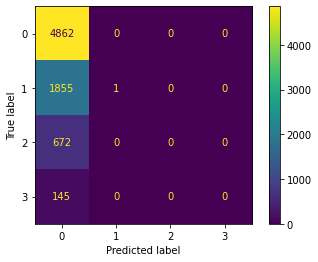

In [68]:
plot_confusion_matrix(ensemble_hard, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

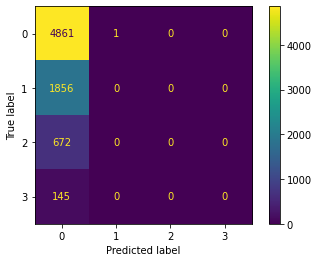

In [69]:
plot_confusion_matrix(ensemble_soft, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

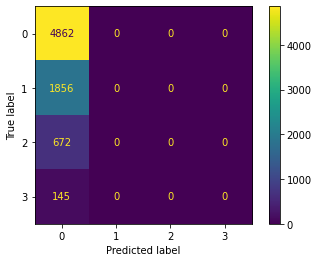

In [70]:
plot_confusion_matrix(svc, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

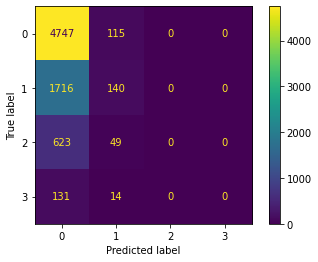

In [71]:
plot_confusion_matrix(knn, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

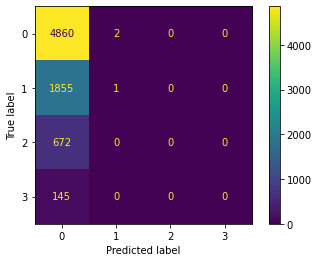

In [72]:
plot_confusion_matrix(ann, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

## itterate variable (finding best variables to be used)

In [73]:
# def combinations(target,data):
#     for i in range(len(data)):
#         yield [*target, data[i]]
#         yield from combinations([*target, data[i]], data[i+1:])

In [74]:
# label_name = 'reaction_time'
# case_names = combinations([],var_names)
# case_names = [case_name for case_name in case_names]

In [75]:
# wrapper_svc = {}
# for case_name in case_names:
#     x_train_temp = x_train[case_name]
#     x_test_temp = x_test[case_name]
#     svc = SVC(**svc_best_params, random_state=random_state)
#     svc.fit(x_train_temp, y_train)
#     y_predict = svc.predict(x_test_temp)
#     accuracy = evaluate(y_test, y_predict)   
#     wrapper_svc[str(case_name)] = accuracy
#     print(f"{case_name}: {accuracy}")
    
# df_wrapper_svc = pd.DataFrame.from_dict(wrapper_svc, orient='index')
# df_wrapper_svc.to_csv(os.path.join(folder_result,'svc.csv'),index=True) 

In [76]:
# wrapper_knn = {}
# for case_name in case_names:
#     x_train_temp = x_train[case_name]
#     x_test_temp = x_test[case_name]
#     knn = KNeighborsClassifier(**knn_best_params)
#     knn.fit(x_train_temp, y_train)
#     y_predict = knn.predict(x_test_temp)
#     accuracy = evaluate(y_test, y_predict)   
#     wrapper_knn[str(case_name)] = accuracy
#     print(f"{case_name}: {accuracy}")
    
# df_wrapper_knn = pd.DataFrame.from_dict(wrapper_knn, orient='index')
# df_wrapper_knn.to_csv(os.path.join(folder_result,'knn.csv'),index=True)

In [77]:
# wrapper_ann = {}
# for case_name in case_names:
#     x_train_temp = x_train[case_name]
#     x_test_temp = x_test[case_name]
#     ann = MLPClassifier(**ann_best_params, random_state=random_state)
#     ann.fit(x_train_temp, y_train)
#     y_predict = ann.predict(x_test_temp)
#     accuracy = evaluate(y_test, y_predict)   
#     wrapper_ann[str(case_name)] = accuracy
#     print(f"{case_name}: {accuracy}")

# df_wrapper_ann = pd.DataFrame.from_dict(wrapper_ann, orient='index')
# df_wrapper_ann.to_csv(os.path.join(folder_result,'ann.csv'),index=True) 

In [78]:
# wrapper_ensemble_hard = {}
# for case_name in case_names:
#     x_train_temp = x_train[case_name]
#     x_test_temp = x_test[case_name]
#     ensemble_hard = VotingClassifier(estimators=[('svc',svc),('knn',knn),('ann',ann)], voting='hard', n_jobs=-1)
#     ensemble_hard.fit(x_train_temp, y_train)
#     y_predict = ensemble_hard.predict(x_test_temp)
#     accuracy = evaluate(y_test, y_predict)    
#     wrapper_ensemble_hard[str(case_name)] = accuracy
#     print(f"{case_name}: {accuracy}")

# df_wrapper_ensemble_hard = pd.DataFrame.from_dict(wrapper_ensemble_hard, orient='index')
# df_wrapper_ensemble_hard.to_csv(os.path.join(folder_path,'ensemble_hard.csv'),index=True) 

In [79]:
# wrapper_ensemble_soft = {}
# for case_name in case_names:
#     x_train_temp = x_train[case_name]
#     x_test_temp = x_test[case_name]
#     ensemble_soft = VotingClassifier(estimators=[('svc', svc),('knn',knn),('ann',ann)], voting='soft', n_jobs=-1)
#     ensemble_soft.fit(x_train_temp, y_train)
#     y_predict = ensemble_soft.predict(x_test_temp)
#     accuracy = evaluate(y_test, y_predict)    
#     wrapper_ensemble_soft[str(case_name)] = accuracy
#     print(f"{case_name}: {accuracy}")

# df_wrapper_ensemble_soft = pd.DataFrame.from_dict(wrapper_ensemble_soft, orient='index')
# df_wrapper_ensemble_soft.to_csv(os.path.join(folder_path,'ensemble_soft.csv'),index=True) 

# HRV-Stress_machine-learning

### mode: jenks, four groups, all variables, 30s hrv window

```python
random_state = 0 # for reproducibility
test_size = 0.2 # 20% data as test data

file_name = 'jenks_reaction_time_penalized_minmax.csv'
var_30_names = ['mrr_30s', 'mhr_30s', 'sdrr_30s', 'sdhr_30s', 'cvrr_30s', 'rmsd_30s', 'prr20_30s', 'prr50_30s']
label_name = 'reaction_time'
```

## imbalance corection and split

In [80]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os.path as osp
import os
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import ClusterCentroids 

In [81]:
random_state = 0 # for reproducibility
test_size = 0.2 # 20% data as test data

In [82]:
folder_path = 'data/collective'
file_name = 'jenks_reaction_time_penalized_minmax.csv'
folder_train = osp.join('data',file_name[:-4],'train')
folder_test = osp.join('data',file_name[:-4],'train')
folder_result = osp.join('data',file_name[:-4],'result')
for f in [folder_train, folder_test, folder_result]:
    if not osp.exists(f):
        os.makedirs(f)
var_names = ['mrr_30s', 'mhr_30s', 'sdrr_30s', 'sdhr_30s', 'cvrr_30s', 'rmsd_30s', 'prr20_30s', 'prr50_30s']
label_name = 'reaction_time'

In [83]:
df = pd.read_csv(osp.join(folder_path,file_name))

In [84]:
x_raw = df[var_names]
x_raw.head()

,mrr_30s,mhr_30s,sdrr_30s,sdhr_30s,cvrr_30s,rmsd_30s,prr20_30s,prr50_30s
0,0.369403,0.561496,0.357458,0.290079,0.272239,0.135309,0.479167,0.537799
1,0.358028,0.569898,0.341373,0.247910,0.258321,0.121904,0.489754,0.550318
2,0.377661,0.549584,0.358769,0.264653,0.269784,0.131907,0.414583,0.537799
3,0.371055,0.572978,0.402266,0.372624,0.325611,0.187001,0.479167,0.577990
4,0.412344,0.522370,0.396878,0.374052,0.298654,0.172982,0.479167,0.577990


In [85]:
y_raw = df[label_name]
y_raw.head()

0    1
1    1
2    0
3    0
4    1
Name: reaction_time, dtype: int64

### mode: Oversampling SMOTETomek

```python
sampling = 'SMOTETomek'
```

In [86]:
print('Original dataset shape %s' % Counter(y_raw))

sampling = 'SMOTETomek'

if sampling == 'ClusterCentroids':
    # under sampling
    cc = ClusterCentroids(sampling_strategy='not minority', random_state=random_state, voting='hard')
    x_res, y_res = cc.fit_resample(x_raw, y_raw)
elif sampling == 'SMOTETomek':
    # over sampling
    smt = SMOTETomek(random_state=random_state)
    x_res, y_res = smt.fit_resample(x_raw, y_raw)

print('Resampled dataset shape %s' % Counter(y_res))

# drop value outside scaler minmax range
x_res[label_name]=y_res
for var_name in var_names:
    x_res.drop(x_res[x_res[var_name] < 0].index, inplace = True)
    x_res.drop(x_res[x_res[var_name] > 1].index, inplace = True)

y_res = x_res[label_name]
x_res.drop(label_name, axis=1, inplace=True) 
print('Resampled dataset shape after minmax filter %s' % Counter(y_res))

Original dataset shape Counter({0: 23999, 1: 9595, 2: 3287, 3: 793})
Resampled dataset shape Counter({3: 23969, 2: 23771, 1: 23012, 0: 23006})
Resampled dataset shape after minmax filter Counter({3: 23940, 2: 23763, 1: 23007, 0: 22987})


In [87]:
x_res.head()

,mrr_30s,mhr_30s,sdrr_30s,sdhr_30s,cvrr_30s,rmsd_30s,prr20_30s,prr50_30s
0,0.369403,0.561496,0.357458,0.290079,0.272239,0.135309,0.479167,0.537799
1,0.358028,0.569898,0.341373,0.247910,0.258321,0.121904,0.489754,0.550318
2,0.377661,0.549584,0.358769,0.264653,0.269784,0.131907,0.414583,0.537799
3,0.371055,0.572978,0.402266,0.372624,0.325611,0.187001,0.479167,0.577990
4,0.412344,0.522370,0.396878,0.374052,0.298654,0.172982,0.479167,0.577990


In [88]:
x_train, x_test, y_train, y_test = train_test_split(x_res,y_res, test_size=test_size, random_state=random_state)

if sampling == 'ClusterCentroids':
    sampling_name = 'cc'
elif sampling == 'SMOTETomek': 
    sampling_name = 'smt'

x_train.to_csv(osp.join(folder_train,'x_train_'+sampling_name+'_res.csv'),index=False)
y_train.to_csv(osp.join(folder_train,'y_train_'+sampling_name+'_res.csv'),index=False)
x_test.to_csv(osp.join(folder_test,'x_test_'+sampling_name+'_res.csv'),index=False)
y_test.to_csv(osp.join(folder_test,'y_test_'+sampling_name+'_res.csv'),index=False)

## evaluation function

In [89]:
# from pprint import pprint

In [90]:
# from sklearn.metrics import r2_score, accuracy_score
# import numpy as np

# def evaluate(y_true, y_predict, complete=False):
#     accuracy = accuracy_score(y_true, y_predict)
#     if complete:
#         n = len(y_true)
#         errors = abs(y_predict - y_true)
#         mean_absolute_error = sum(errors) / n
#         mean_squared_error = sum(np.power(errors,2)) / n
#         root_mean_squared_error = np.sqrt(mean_squared_error)
#         mean_absolute_percentage_error = sum(errors / y_true) / n
#         accuracy_mape =  1 - mean_absolute_percentage_error
#         r_square = r2_score(y_true, y_predict)

#         return {
#             'mean_absolute_error': mean_absolute_error,
#             'mean_squared_error': mean_squared_error,
#             'root_mean_squared_error': root_mean_squared_error,
#             'mean_absolute_percentage_error': mean_absolute_percentage_error,
#             'accuracy mape': accuracy_mape,
#             'accuracy': accuracy,
#             'r_square': r_square
#         }
#     else:
#         return {
#             'accuracy': accuracy,
#         }

In [91]:
from sklearn.svm import SVC
# svc = SVC(kernel='rbf', decision_function_shape='ovo', random_state=random_state)
# svc.fit(x_train, y_train)
# y_predict = svc.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

In [92]:
from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors=10)
# knn.fit(x_train, y_train)
# y_predict = knn.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

In [93]:
from sklearn.neural_network import MLPClassifier
# ann = MLPClassifier(solver='adam', hidden_layer_sizes=(20, 20), activation='relu', random_state=random_state, max_iter=2000)
# ann.fit(x_train, y_train)
# y_predict = ann.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

## grid search

In [94]:
from sklearn.model_selection import GridSearchCV

In [95]:
# # Create the parameter grid based on the results of random search 
# param_grid_svc = {
#     'decision_function_shape': ['ovo', 'ovr'],
#     'kernel': ['linear', 'poly', 'rbf'],
#     'degree': [3],
#     'gamma': ['scale'],
#     'probability'=[True]
# }
# svc = SVC()

# # Instantiate the grid search model
# grid_svc = GridSearchCV(estimator = svc, param_grid = param_grid_svc, cv = 5, n_jobs = -1)

# # Fit the grid search to the data
# grid_svc.fit(x_train, y_train)
# svc_best_params = grid_svc.best_params_
# pprint(svc_best_params)

# svc = SVC(**svc_best_params, random_state=random_state)
# svc.fit(x_train, y_train)
# y_predict = svc.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

# # # result
# # {'decision_function_shape': 'ovo',
# #  'degree': 3,
# #  'gamma': 'scale',
# #  'kernel': 'linear'}
# # {'accuracy': 0.49007444168734493}
svc_best_params = {
    'decision_function_shape': 'ovo',
    'degree': 3,
    'gamma': 'scale',
    'kernel': 'linear',
    'probability':True
}
svc = SVC(**svc_best_params, random_state=random_state)

In [96]:
# # Create the parameter grid based on the results of random search 
# param_grid_knn = {
#     'n_neighbors': [3, 15, 27, 39, 51, 63, 75, 87, 99]
# }

# knn = KNeighborsClassifier()
# # Instantiate the grid search model
# grid_knn = GridSearchCV(estimator = knn, param_grid = param_grid_knn, cv = 5, n_jobs = -1)

# # Fit the grid search to the data
# grid_knn.fit(x_train, y_train)
# knn_best_params = grid_knn.best_params_
# pprint(knn_best_params)

# knn = KNeighborsClassifier(**knn_best_params)
# knn.fit(x_train, y_train)
# y_predict = knn.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

# # # result
# # {'n_neighbors': 51}
# # {'accuracy': 0.4987593052109181}

knn_best_params = {
    'n_neighbors': 51
}
knn = KNeighborsClassifier(**knn_best_params)

In [97]:
# # Create the parameter grid based on the results of random search 
# param_grid_ann = {
#     'solver': ['lbfgs', 'sgd', 'adam'],
#     'activation': ['identity', 'logistic', 'tanh', 'relu'],
#     'hidden_layer_sizes': [(10, 10), (20, 20), (20, 10), (10, 20)],
#     'max_iter': [2000] 
# }
# ann = MLPClassifier()

# # Instantiate the grid search model
# grid_ann = GridSearchCV(estimator = ann, param_grid = param_grid_ann, cv = 5, n_jobs = -1, error_score=0)

# # Fit the grid search to the data
# grid_ann.fit(x_train, y_train)
# ann_best_params = grid_ann.best_params_
# pprint(ann_best_params)

# ann = MLPClassifier(**ann_best_params, random_state=random_state)
# ann.fit(x_train, y_train)
# y_predict = ann.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

# # # result
# # {'activation': 'relu',
# #  'hidden_layer_sizes': (10, 20),
# #  'max_iter': 2000,
# #  'solver': 'adam'}
# # {'accuracy': 0.5}

ann_best_params = {
    'activation': 'relu',
    'hidden_layer_sizes': (10, 20),
    'max_iter': 2000,
    'solver': 'adam'
}
ann = MLPClassifier(**ann_best_params, random_state=random_state)

## ensemble vs individual

In [98]:
import pickle
from sklearn.ensemble import VotingClassifier

In [99]:
ensemble_hard = VotingClassifier(estimators=[('svc', svc), ('knn', knn), ('ann', ann)], voting='hard')
ensemble_hard.fit(x_train, y_train)
y_predict = ensemble_hard.predict(x_test)
accuracy = evaluate(y_test, y_predict)
pprint(accuracy)

filename = 'ensemble_hard.pickle'
pickle.dump(ensemble_hard, open(osp.join(folder_result,filename), 'wb'))

{'accuracy': 0.44060832443970116}


In [100]:
ensemble_soft = VotingClassifier(estimators=[('svc', svc), ('knn', knn), ('ann', ann)], voting='soft')
ensemble_soft.fit(x_train, y_train)
y_predict = ensemble_soft.predict(x_test)
accuracy = evaluate(y_test, y_predict)
pprint(accuracy)

filename = 'ensemble_soft.pickle'
pickle.dump(ensemble_soft, open(osp.join(folder_result,filename), 'wb'))

{'accuracy': 0.5887406616862326}


In [101]:
svc.fit(x_train, y_train)
y_predict = svc.predict(x_test)
accuracy = evaluate(y_test, y_predict)
pprint(accuracy)

filename = 'svc.pickle'
pickle.dump(svc, open(osp.join(folder_result,filename), 'wb'))

knn.fit(x_train, y_train)
y_predict = knn.predict(x_test)
accuracy = evaluate(y_test, y_predict)
pprint(accuracy)

filename = 'knn.pickle'
pickle.dump(knn, open(osp.join(folder_result,filename), 'wb'))

ann.fit(x_train, y_train)
y_predict = ann.predict(x_test)
accuracy = evaluate(y_test, y_predict)
pprint(accuracy)

filename = 'ann.pickle'
pickle.dump(ann, open(osp.join(folder_result,filename), 'wb'))

{'accuracy': 0.285752401280683}
{'accuracy': 0.6084845250800427}
{'accuracy': 0.3593383137673426}


## confusion matrix

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

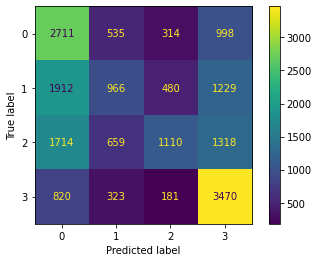

In [103]:
plot_confusion_matrix(ensemble_hard, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

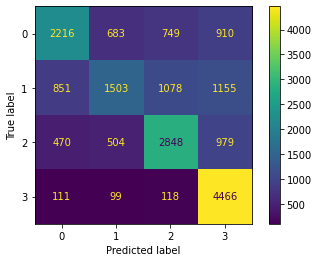

In [104]:
plot_confusion_matrix(ensemble_soft, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

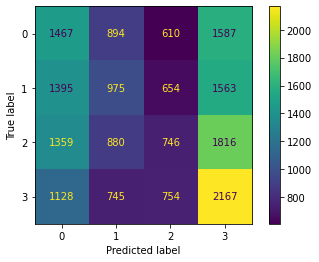

In [105]:
plot_confusion_matrix(svc, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

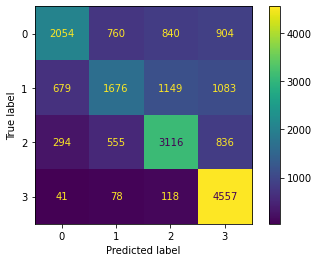

In [106]:
plot_confusion_matrix(knn, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

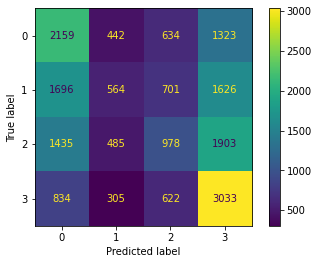

In [107]:
plot_confusion_matrix(ann, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

## test on original data

In [108]:
x_ori_test = pd.read_csv(osp.join(folder_test,'x_test.csv'))
x_ori_test.head()

,mrr_30s,mhr_30s,sdrr_30s,sdhr_30s,cvrr_30s,rmsd_30s,prr20_30s,prr50_30s
0,0.617649,0.405224,0.392600,0.573002,0.395477,0.194336,0.447025,0.439394
1,0.294458,0.697849,0.467890,0.675078,0.577218,0.513988,0.602137,0.426335
2,0.526531,0.471133,0.784228,0.791752,0.870543,0.532814,0.605455,0.657576
3,0.811769,0.181544,0.847339,0.673437,0.625400,0.861938,0.797353,0.748428
4,0.552970,0.372572,0.406598,0.473156,0.396572,0.450568,0.699650,0.496286


In [109]:
y_ori_test = pd.read_csv(osp.join(folder_test,'y_test.csv'))
y_ori_test.head()

,reaction_time
0,0
1,1
2,1
3,2
4,0


{'accuracy': 0.47285998672859986}


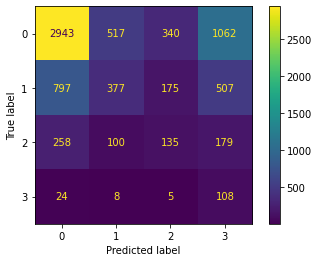

In [110]:
y_predict = ensemble_hard.predict(x_ori_test)
accuracy = evaluate(y_ori_test, y_predict)
pprint(accuracy)
plot_confusion_matrix(ensemble_hard, x_ori_test, y_ori_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

{'accuracy': 0.45958858659588586}


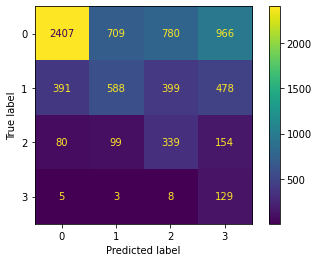

In [111]:
y_predict = ensemble_soft.predict(x_ori_test)
accuracy = evaluate(y_ori_test, y_predict)
pprint(accuracy)
plot_confusion_matrix(ensemble_soft, x_ori_test, y_ori_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

{'accuracy': 0.2911745189117452}


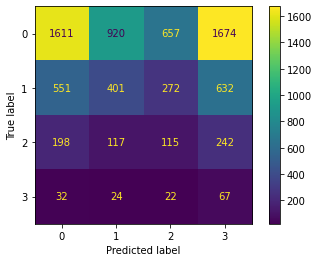

In [112]:
y_predict = svc.predict(x_ori_test)
accuracy = evaluate(y_ori_test, y_predict)
pprint(accuracy)
plot_confusion_matrix(svc, x_ori_test, y_ori_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

{'accuracy': 0.45215660252156603}


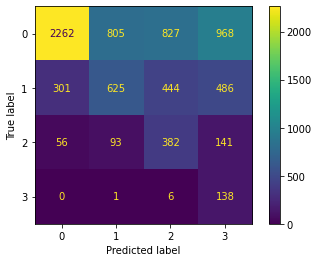

In [113]:
y_predict = knn.predict(x_ori_test)
accuracy = evaluate(y_ori_test, y_predict)
pprint(accuracy)
plot_confusion_matrix(knn, x_ori_test, y_ori_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

{'accuracy': 0.375315195753152}


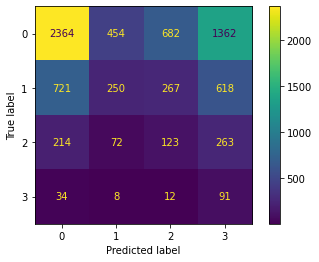

In [114]:
y_predict = ann.predict(x_ori_test)
accuracy = evaluate(y_ori_test, y_predict)
pprint(accuracy)
plot_confusion_matrix(ann, x_ori_test, y_ori_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

## itterate variable (finding best variables to be used)

In [115]:
# def combinations(target,data):
#     for i in range(len(data)):
#         yield [*target, data[i]]
#         yield from combinations([*target, data[i]], data[i+1:])

In [116]:
# label_name = 'reaction_time'
# case_names = combinations([],var_names)
# case_names = [case_name for case_name in case_names]

In [117]:
# wrapper_svc = {}
# for case_name in case_names:
#     x_train_temp = x_train[case_name]
#     x_test_temp = x_test[case_name]
#     svc = SVC(**svc_best_params, random_state=random_state)
#     svc.fit(x_train_temp, y_train)
#     y_predict = svc.predict(x_test_temp)
#     accuracy = evaluate(y_test, y_predict)   
#     wrapper_svc[str(case_name)] = accuracy
#     print(f"{case_name}: {accuracy}")
    
# df_wrapper_svc = pd.DataFrame.from_dict(wrapper_svc, orient='index')
# df_wrapper_svc.to_csv(os.path.join(folder_result,'svc.csv'),index=True) 

In [118]:
# wrapper_knn = {}
# for case_name in case_names:
#     x_train_temp = x_train[case_name]
#     x_test_temp = x_test[case_name]
#     knn = KNeighborsClassifier(**knn_best_params)
#     knn.fit(x_train_temp, y_train)
#     y_predict = knn.predict(x_test_temp)
#     accuracy = evaluate(y_test, y_predict)   
#     wrapper_knn[str(case_name)] = accuracy
#     print(f"{case_name}: {accuracy}")
    
# df_wrapper_knn = pd.DataFrame.from_dict(wrapper_knn, orient='index')
# df_wrapper_knn.to_csv(os.path.join(folder_result,'knn.csv'),index=True)

In [119]:
# wrapper_ann = {}
# for case_name in case_names:
#     x_train_temp = x_train[case_name]
#     x_test_temp = x_test[case_name]
#     ann = MLPClassifier(**ann_best_params, random_state=random_state)
#     ann.fit(x_train_temp, y_train)
#     y_predict = ann.predict(x_test_temp)
#     accuracy = evaluate(y_test, y_predict)   
#     wrapper_ann[str(case_name)] = accuracy
#     print(f"{case_name}: {accuracy}")

# df_wrapper_ann = pd.DataFrame.from_dict(wrapper_ann, orient='index')
# df_wrapper_ann.to_csv(os.path.join(folder_result,'ann.csv'),index=True) 

In [120]:
# wrapper_ensemble_hard = {}
# for case_name in case_names:
#     x_train_temp = x_train[case_name]
#     x_test_temp = x_test[case_name]
#     ensemble_hard = VotingClassifier(estimators=[('svc',svc),('knn',knn),('ann',ann)], voting='hard', n_jobs=-1)
#     ensemble_hard.fit(x_train_temp, y_train)
#     y_predict = ensemble_hard.predict(x_test_temp)
#     accuracy = evaluate(y_test, y_predict)    
#     wrapper_ensemble_hard[str(case_name)] = accuracy
#     print(f"{case_name}: {accuracy}")

# df_wrapper_ensemble_hard = pd.DataFrame.from_dict(wrapper_ensemble_hard, orient='index')
# df_wrapper_ensemble_hard.to_csv(os.path.join(folder_path,'ensemble_hard.csv'),index=True) 

In [121]:
# wrapper_ensemble_soft = {}
# for case_name in case_names:
#     x_train_temp = x_train[case_name]
#     x_test_temp = x_test[case_name]
#     ensemble_soft = VotingClassifier(estimators=[('svc', svc),('knn',knn),('ann',ann)], voting='soft', n_jobs=-1)
#     ensemble_soft.fit(x_train_temp, y_train)
#     y_predict = ensemble_soft.predict(x_test_temp)
#     accuracy = evaluate(y_test, y_predict)    
#     wrapper_ensemble_soft[str(case_name)] = accuracy
#     print(f"{case_name}: {accuracy}")

# df_wrapper_ensemble_soft = pd.DataFrame.from_dict(wrapper_ensemble_soft, orient='index')
# df_wrapper_ensemble_soft.to_csv(os.path.join(folder_path,'ensemble_soft.csv'),index=True) 